<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_RNN_altSequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### Create temporal sequence data

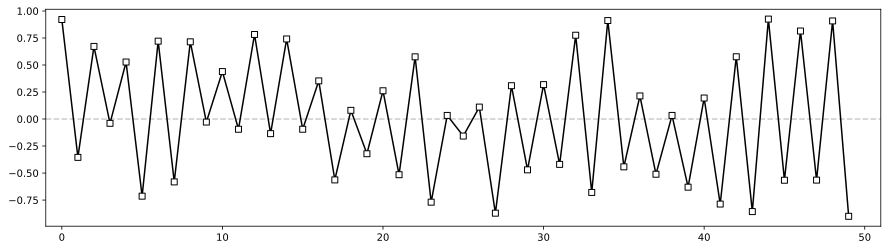

In [2]:
# import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(15, 4))
plt.plot([-1, N+1], [0, 0], '--', color=[.8, .8, .8])
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-1, N+1])
plt.show()

## Create a class for the DL model

In [3]:
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):

        # run through the RNN layer
        y, hidden = self.rnn(x)         # no explicit hidden state initialization
        
        # and the output (linear) layer
        y = self.out(y)
        
        return y, hidden

In [5]:
# network parameters
input_size  =   1   # "channels" of data
num_hidden  =   5   # breadth of model (number of units in hidden layers)
num_layers  =   1   # depth of model (number of "stacks" of hidden layers)
seqlength   =   9   # number of datapoints used for learning in each segment
batchsize   =   1   # Note: the training code is actually hard-coded to organize data into batch

# create an instance of the model and inspect
net = rnnnet(input_size, num_hidden, num_layers)

X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X)
print(X.shape)
print(y.shape)  # note: one output per sequence element; generally, we take the final output
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [6]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue, data[seqlength].view(1, 1))

tensor(0.2358, grad_fn=<MseLossBackward0>)

## Train the model and show performance

In [7]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seglosses  = []
    segacc     = []
    hidden_state = torch.zeros(num_layers, batchsize, num_hidden)  # reset the hidden state

    for timei in range(N-seqlength):

        # grab a snippet of data
        X = data[timei:timei+seqlength].view(seqlength, 1, 1)
        y = data[timei+seqlength].view(1,1)

        # forward pass and loss
        yHat, hidden_state = net(X)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y)  # compare final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

        # also get sign accuracy
        truesign = np.sign(torch.squeeze(y).numpy())
        predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
        accuracy = 100 * (truesign == predsign)
        segacc.append(accuracy)

    # average losses from this epoch
    losses[epochi] = np.mean(seglosses)
    signaccuracy[epochi] = np.mean(segacc)

    msg = f'Finished epoch {epochi+1}/{numepochs}'
    sys.stdout.write('\r' + msg)



Finished epoch 30/30

In [8]:
truesign

-1.0

In [9]:
predsign

-1.0

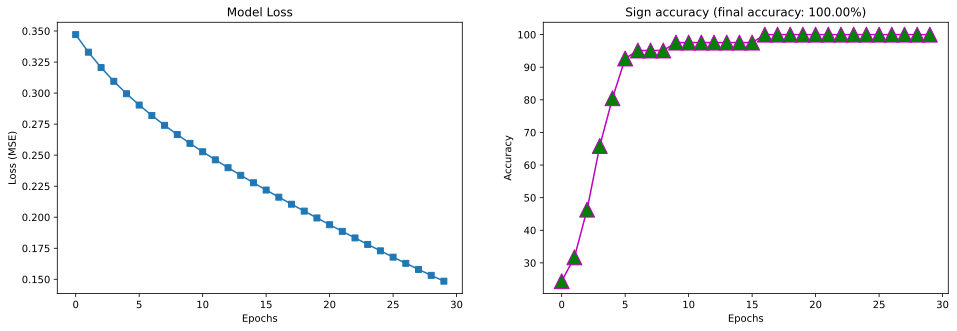

In [10]:
## let's see how the model did!

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model Loss')

ax[1].plot(signaccuracy, 'm^-', markerfacecolor='g', markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

## Now test the network!

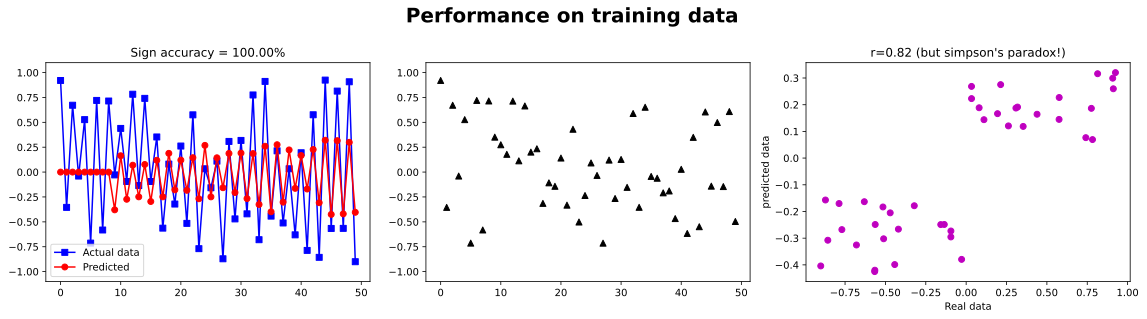

In [11]:
# initialize hidden state
h = np.zeros((N, num_hidden))

# initialize predicted value
yHat = np.zeros(N)

# loop over time segments
for timei in range(N-seqlength):

    # grab a snipped of data
    X = data[timei:timei+seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei+seqlength, :] = hh.detach()

### compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100 * np.mean(truesign[seqlength:] == predsign[seqlength:])

## plot!
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(data, 'bs-', label='Actual data')
ax[0].plot(yHat, 'ro-', label='Predicted')
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title('Sign accuracy = %.2f%%'%signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat, 'k^')
ax[1].set_ylim([-1.1, 1.1])

ax[2].plot(data[seqlength:], yHat[seqlength:], 'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('predicted data')
r = np.corrcoef(data[seqlength:], yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but simpson's paradox!)")

plt.suptitle('Performance on training data', fontweight='bold', fontsize=20, y=1.1)
plt.tight_layout()
plt.show()

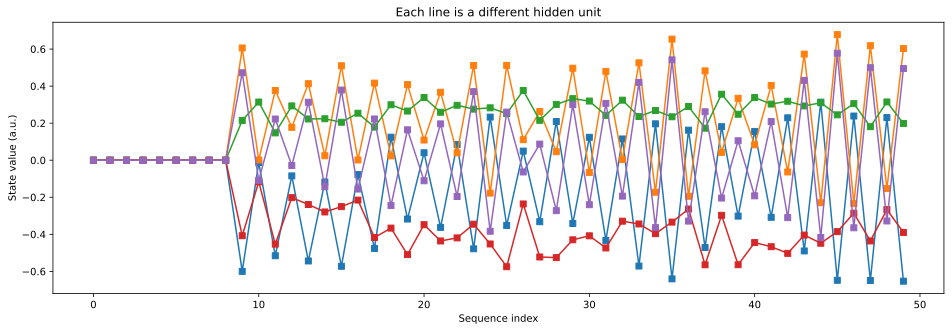

In [12]:
 # show the hidden "states" (units activations)
 plt.figure(figsize=(16, 5))

 plt.plot(h, 's-')
 plt.xlabel('Sequence index')
 plt.ylabel('State value (a.u.)')
 plt.title('Each line is a different hidden unit')
 plt.show()

# Test with new data

In [13]:
# create new data WITH FLIPPED SIGNS
newdata = torch.zeros(N)
for i in range(N):
    newdata[i] = torch.rand(1) * (-1)**(i+1)

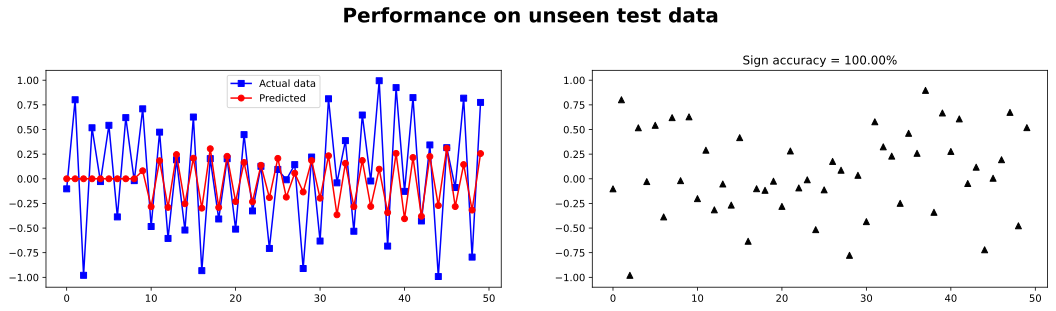

In [14]:
## now test the network
# note: no learning here!

h = np.zeros((N, num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

     # grab a snippet of data
     X = newdata[timei:timei+seqlength].view(seqlength, 1, 1)

     # forward pass and loss
     yy, hh = net(X)
     yHat[timei+seqlength] = yy[-1]
     h[timei+seqlength, :] = hh.detach()

# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100 * np.mean(truesign[seqlength:] == predsign[seqlength:])

fig, ax = plt.subplots(1,2, figsize=(18, 4))
ax[0].plot(newdata, 'bs-', label='Actual data')
ax[0].plot(yHat, 'ro-', label='Predicted')
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(newdata-yHat, 'k^')
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title('Sign accuracy = %.2f%%'%signaccuracy)

plt.suptitle('Performance on unseen test data', fontweight='bold', fontsize=20, y=1.1)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


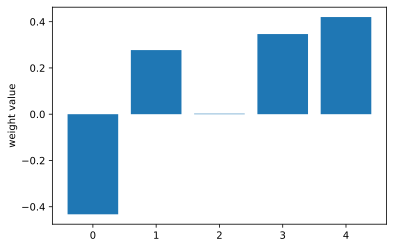

In [15]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden), net.rnn.weight_ih_l0.detach())
plt.ylabel('weight value')
plt.show()